# Importing libraries and loading dataset

In [1]:
# Starting from loading the libraries required for analysis
# This was first done step by step with each model and cell but was combined finally to make the file cleaner and shorter 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid


In [2]:
# Loading data
file_path = 'Monthly_New.csv'
data = pd.read_csv(file_path)

# First few rows
data.head()


,Year,Month,TotalPrimaryEnergyConsumption,TotalPrimaryEnergyProduction,TotalPrimaryEnergyExports,TotalPrimaryEnergyImports,TotalPrimaryEnergyConsumedbytheIndustrialSector,TotalPrimaryEnergyConsumedbytheResidentialSector,PrimaryEnergyStockChange
0,1973,1,7223.87,5404.72,125.78,1173.08,2027.03,1339.27,771.858
1,1973,2,6592.37,5155.12,120.88,1168.01,1841.30,1174.90,390.129
2,1973,3,6521.44,5419.56,139.95,1309.47,1926.41,983.37,-67.640
3,1973,4,5941.73,5160.81,194.19,1085.17,1914.02,715.39,-110.067
4,1973,5,6071.94,5411.25,196.78,1162.80,2076.47,535.91,-305.335


In [3]:
print(data)

     Year  Month  TotalPrimaryEnergyConsumption  TotalPrimaryEnergyProduction  \
0    1973      1                        7223.87                       5404.72   
1    1973      2                        6592.37                       5155.12   
2    1973      3                        6521.44                       5419.56   
3    1973      4                        5941.73                       5160.81   
4    1973      5                        6071.94                       5411.25   
..    ...    ...                            ...                           ...   
595  2022      8                        8518.83                       8813.29   
596  2022      9                        7772.71                       8562.48   
597  2022     10                        7800.77                       8758.59   
598  2022     11                        8273.91                       8625.49   
599  2022     12                        9066.26                       8668.38   

     TotalPrimaryEnergyExpo

# Checking for any missing values 

In [4]:
missing_values = data.isnull().sum()
missing_values_percentage = (data.isnull().sum() / len(data)) * 100

missing_data_info = pd.DataFrame({
    'Missing Values': missing_values, 
    'Percentage': missing_values_percentage
})

missing_data_info


,Missing Values,Percentage
Year,0,0.0
Month,0,0.0
TotalPrimaryEnergyConsumption,0,0.0
TotalPrimaryEnergyProduction,0,0.0
TotalPrimaryEnergyExports,0,0.0
TotalPrimaryEnergyImports,0,0.0
TotalPrimaryEnergyConsumedbytheIndustrialSector,0,0.0
TotalPrimaryEnergyConsumedbytheResidentialSector,0,0.0
PrimaryEnergyStockChange,0,0.0


## Converting data into time series format

In [5]:
# Creating a unique identifier(t) for each year (sequence from 1 to 74) - To use it as a feature while building models
# Combining 'Year' and 'Month' columns into a new 'Date' column which displays time-series format

data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str), format='%Y-%m')
data['t'] = range(1, len(data) + 1)

print(data.head())
data.info()




   Year  Month  TotalPrimaryEnergyConsumption  TotalPrimaryEnergyProduction  \
0  1973      1                        7223.87                       5404.72   
1  1973      2                        6592.37                       5155.12   
2  1973      3                        6521.44                       5419.56   
3  1973      4                        5941.73                       5160.81   
4  1973      5                        6071.94                       5411.25   

   TotalPrimaryEnergyExports  TotalPrimaryEnergyImports  \
0                     125.78                    1173.08   
1                     120.88                    1168.01   
2                     139.95                    1309.47   
3                     194.19                    1085.17   
4                     196.78                    1162.80   

   TotalPrimaryEnergyConsumedbytheIndustrialSector  \
0                                          2027.03   
1                                          1841.30   
2       

## Winters Exponential smoothing before Hypertuining - Production



Training Set Metrics:
MAE: 102.93
RMSE: 141.33
MAPE: 1.78%

Validation Set Metrics:
MAE: 828.28
RMSE: 922.88
MAPE: 9.97%


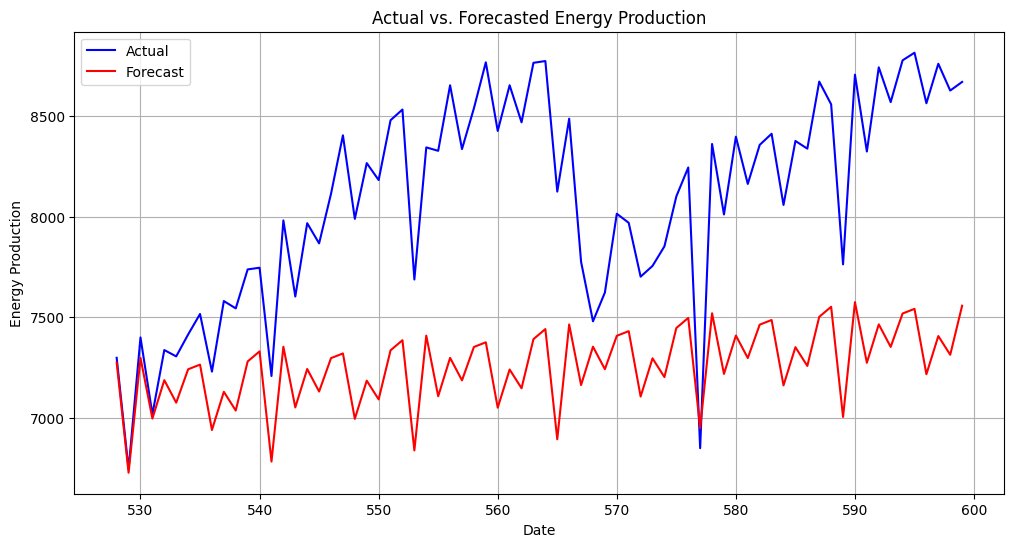

In [6]:
# Splitting the data into a training set (1973-2016) and a test set (2017-2022)
train_start_date = pd.to_datetime('1973-01-01')
train_end_date = pd.to_datetime('2016-12-31')
validation_start_date = pd.to_datetime('2017-01-01')
validation_end_date = pd.to_datetime('2022-12-31')

# Defining featues and target variable
features = ['TotalPrimaryEnergyConsumption', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports', 't']
target = 'TotalPrimaryEnergyProduction'

# Creating training and validation data subsets with features and target
train_data = data[(data['Date'] >= train_start_date) & (data['Date'] <= train_end_date)]
validation_data = data[(data['Date'] >= validation_start_date) & (data['Date'] <= validation_end_date)]

# Winter's Exponential Smoothing model
model = ExponentialSmoothing(train_data[target], trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Forecasting on the validation data
forecast_validation = model_fit.forecast(steps=len(validation_data))

# Evaluation metrics for training
mae_train = mean_absolute_error(train_data[target], model_fit.fittedvalues)
mse_train = mean_squared_error(train_data[target], model_fit.fittedvalues)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((train_data[target] - model_fit.fittedvalues) / (train_data[target] + 1e-10))) * 100

# Evaluation metrics for validation
mae_validation = mean_absolute_error(validation_data[target], forecast_validation)
mse_validation = mean_squared_error(validation_data[target], forecast_validation)
rmse_validation = np.sqrt(mse_validation)
mape_validation = np.mean(np.abs((validation_data[target] - forecast_validation) / (validation_data[target] + 1e-10))) * 100

# Results
print("Training Set Metrics:")
print(f"MAE: {mae_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")

print("\nValidation Set Metrics:")
print(f"MAE: {mae_validation:.2f}")
print(f"RMSE: {rmse_validation:.2f}")
print(f"MAPE: {mape_validation:.2f}%")

# Ploting the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(validation_data.index, validation_data[target], label='Actual', color='blue')
plt.plot(validation_data.index, forecast_validation, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.title('Actual vs. Forecasted Energy Production')
plt.legend()
plt.grid()
plt.show()


**Analysis**:
The matrix above displays metrics such as MAE, RMSE, and MAPE. Notably, these metrics are lower for the training set and higher for the validation set, indicating potential overfitting. To address this concern, I plan to conduct hyperparameter tuning to identify optimal parameters. Subsequently, I will reapply the Winter's Exponential model.




## Performing Hypertuining to check the best parameters

In [ ]:
# Splitting the data into a training set (1973-2016) and a test set (2017-202
train_start_date = pd.to_datetime('1973-01-01')
train_end_date = pd.to_datetime('2016-12-31')
validation_start_date = pd.to_datetime('2017-01-01')
validation_end_date = pd.to_datetime('2022-12-31')

# Create training and validation data subsets with features and target
train_data = data[(data['Date'] >= train_start_date) & (data['Date'] <= train_end_date)]
validation_data = data[(data['Date'] >= validation_start_date) & (data['Date'] <= validation_end_date)]

# Defining featues and target variable
features = ['TotalPrimaryEnergyConsumption', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports', 't']
target = 'TotalPrimaryEnergyProduction'

# Defining a grid of hyperparameters to search
param_grid = {
    'seasonal': ['add', 'additive', 'multiplicative'],
    'seasonal_periods': [6, 12],
    'trend': ['add', 'additive', 'multiplicative'],
    'damped': [True, False]
}

# Creating an empty dictionary to store the results
results = {}

# Iterating through the parameter grid
for params in ParameterGrid(param_grid):
    model_production = ExponentialSmoothing(
        train_data[target],
        seasonal=params['seasonal'],
        seasonal_periods=params['seasonal_periods'],
        trend=params['trend'],
        damped=params['damped']
    )
    model_production_fit = model_production.fit()
    
    # Forecasting on the validation data
    forecast_validation = model_production_fit.forecast(steps=len(validation_data))
    
    # Mean Absolute Percentage Error (MAPE)
    mape_production_validation = np.mean(np.abs((validation_data[target] - forecast_validation) / validation_data[target])) * 100
    
    # Storing the results with the hyperparameters as the key
    results[str(params)] = mape_production_validation

# Finding the hyperparameters that minimize MAPE
best_params = min(results, key=results.get)
best_mape = results[best_params]

print("Best Hyperparameters:", best_params)
print("Lowest MAPE:", best_mape)


**Results**: 
Best Hyperparameters: {'damped': False, 'seasonal': 'multiplicative', 'seasonal_periods': 6, 'trend': 'multiplicative'}
Lowest MAPE: 8.645665135071205

## Winters Exponential smoothing after Hypertuining - Production

C:\Users\student\AppData\Local\Temp\ipykernel_17192\123927025.py:25: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(


Training Set Metrics:
MAE: 169.03
RMSE: 213.45
MAPE: 2.91%

Validation Set Metrics:
MAE: 522.50
RMSE: 624.00
MAPE: 6.30%


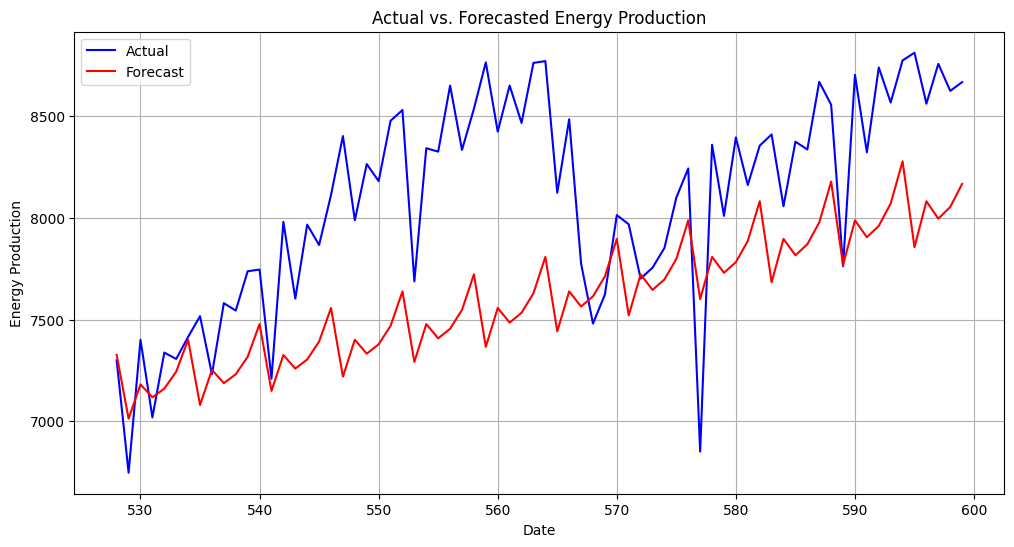

In [8]:
# Splitting the data into a training set (1973-2016) and a test set (2017-2022)
train_start_date = pd.to_datetime('1973-01-01')
train_end_date = pd.to_datetime('2016-12-31')
validation_start_date = pd.to_datetime('2017-01-01')
validation_end_date = pd.to_datetime('2022-12-31')

# Defining featues and target variable
features = ['TotalPrimaryEnergyConsumption', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports', 't']
target = 'TotalPrimaryEnergyProduction'

# Creating training and validation data subsets with features and target
train_data = data[(data['Date'] >= train_start_date) & (data['Date'] <= train_end_date)]
validation_data = data[(data['Date'] >= validation_start_date) & (data['Date'] <= validation_end_date)]

# Best hyperparameters obtained from tuning
best_hyperparameters = {
    'damped': False,
    'seasonal': 'multiplicative',
    'seasonal_periods': 6,
    'trend': 'multiplicative',
    'use_boxcox': True
}

# Winter's Exponential Smoothing model with best hyperparameters
model = ExponentialSmoothing(
    train_data[target],
    seasonal=best_hyperparameters['seasonal'],
    seasonal_periods=best_hyperparameters['seasonal_periods'],
    trend=best_hyperparameters['trend'],
    damped=best_hyperparameters['damped'],
    use_boxcox=best_hyperparameters['use_boxcox']
)
model_fit = model.fit()

# Forecasting on the validation data
forecast_validation = model_fit.forecast(steps=len(validation_data))

# Evaluation metrics for training
mae_train = mean_absolute_error(train_data[target], model_fit.fittedvalues)
mse_train = mean_squared_error(train_data[target], model_fit.fittedvalues)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((train_data[target] - model_fit.fittedvalues) / (train_data[target] + 1e-10))) * 100

# Evaluation metrics for validation
mae_validation = mean_absolute_error(validation_data[target], forecast_validation)
mse_validation = mean_squared_error(validation_data[target], forecast_validation)
rmse_validation = np.sqrt(mse_validation)
mape_validation = np.mean(np.abs((validation_data[target] - forecast_validation) / (validation_data[target] + 1e-10))) * 100

# Results
print("Training Set Metrics:")
print(f"MAE: {mae_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")

print("\nValidation Set Metrics:")
print(f"MAE: {mae_validation:.2f}")
print(f"RMSE: {rmse_validation:.2f}")
print(f"MAPE: {mape_validation:.2f}%")

# Plotting the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(validation_data.index, validation_data[target], label='Actual', color='blue')
plt.plot(validation_data.index, forecast_validation, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.title('Actual vs. Forecasted Energy Production')
plt.legend()
plt.grid()
plt.show()


**Analysis**:

In the matrix above, MAE, RMSE, and MAPE are noted to be lower for the training set and higher for the validation set. Following the implementation of hyperparameter tuning, overfitting is noticeably reduced, resulting in improved outcomes. This enhancement is evident in the Actual and Forecast plots for Production.




## Winters Exponential smoothing before hypertuining - Consumption

Training Set Metrics:
MAE: 142.96
RMSE: 181.61
MAPE: 1.95%

Validation Set Metrics:
MAE: 714.28
RMSE: 864.72
MAPE: 8.48%


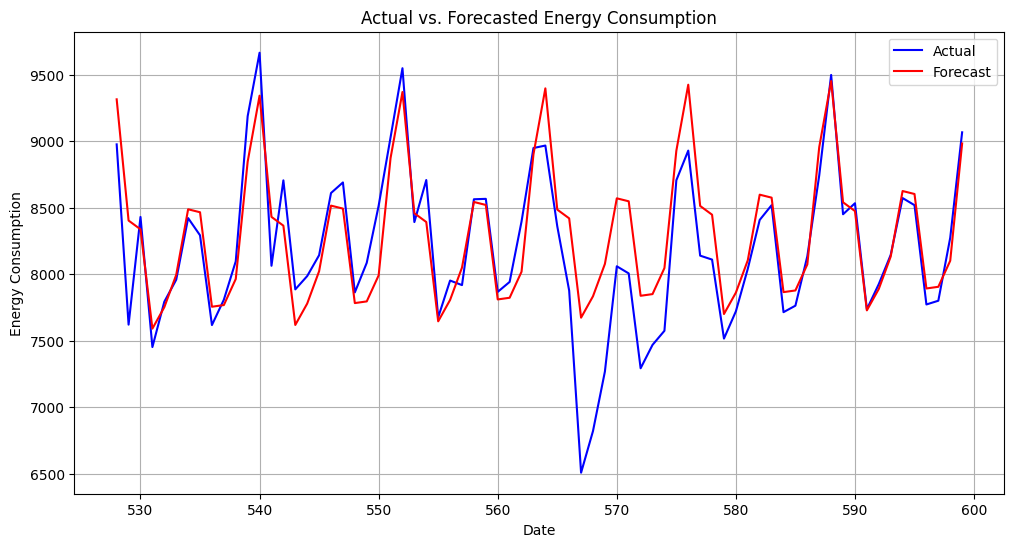

In [9]:
# Splitting the data into a training set (1973-2016) and a test set (2017-2022)
train_start_date = pd.to_datetime('1973-01-01')
train_end_date = pd.to_datetime('2016-12-31')
validation_start_date = pd.to_datetime('2017-01-01')
validation_end_date = pd.to_datetime('2022-12-31')

# Defining featues and target variable
features = ['TotalPrimaryEnergyProduction', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports', 't', 'PrimaryEnergyStockChange']
target = ['TotalPrimaryEnergyConsumption']


# Creating training and validation data subsets
train_consumption = data[(data['Date'] >= train_start_date) & (data['Date'] <= train_end_date)]['TotalPrimaryEnergyConsumption']
validation_consumption = data[(data['Date'] >= validation_start_date) & (data['Date'] <= validation_end_date)]['TotalPrimaryEnergyConsumption']

# Winter's Exponential Smoothing model for production on 'energyt'
model_consumption = ExponentialSmoothing(train_consumption, trend='add', seasonal='add', seasonal_periods=12)
model_consumption_fit = model_consumption.fit()

# Forecasting on the validation data for production
forecast_consumption = model_consumption_fit.forecast(steps=len(validation_consumption))

# Evaluation metrics for training
mae_train = mean_absolute_error(train_consumption, model_consumption_fit.fittedvalues)
mse_train = mean_squared_error(train_consumption, model_consumption_fit.fittedvalues)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((train_consumption - model_consumption_fit.fittedvalues) / train_consumption)) * 100

# Evaluation metrics for validation
mae_validation = mean_absolute_error(validation_consumption, forecast_validation)
mse_validation = mean_squared_error(validation_consumption, forecast_validation)
rmse_validation = np.sqrt(mse_validation)
mape_validation = np.mean(np.abs((validation_consumption - forecast_validation) / validation_consumption)) * 100

# Results
print("Training Set Metrics:")
print(f"MAE: {mae_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")

print("\nValidation Set Metrics:")
print(f"MAE: {mae_validation:.2f}")
print(f"RMSE: {rmse_validation:.2f}")
print(f"MAPE: {mape_validation:.2f}%")

# Plotting the actual and predicted values for production
plt.figure(figsize=(12, 6))
plt.plot(validation_consumption.index, validation_consumption, label='Actual', color='blue')
plt.plot(validation_consumption.index, forecast_consumption, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Actual vs. Forecasted Energy Consumption')
plt.legend()
plt.grid()
plt.show()



**Analysis**:

The matrix above reveals lower MAE, RMSE, and MAPE values for the training set compared to the validation set, suggesting potential overfitting. To tackle this issue, I plan to conduct hyperparameter tuning to identify optimal parameters and subsequently re-fit the Winter's Exponential model.




## Hypertuining to see what is best to use in order to improve forecast MAPE.



In [ ]:
# Splitting the data into a training set (1973-2016) and a test set (2017-2022)
train_start_date = pd.to_datetime('1973-01-01')
train_end_date = pd.to_datetime('2016-12-31')
validation_start_date = pd.to_datetime('2017-01-01')
validation_end_date = pd.to_datetime('2022-12-31')

# Creating training and validation data subsets with features and target
train_data = data[(data['Date'] >= train_start_date) & (data['Date'] <= train_end_date)]
validation_data = data[(data['Date'] >= validation_start_date) & (data['Date'] <= validation_end_date)]

# Defining featues and target variable
features = ['TotalPrimaryEnergyProduction', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports', 't', 'PrimaryEnergyStockChange']
target = 'TotalPrimaryEnergyConsumption'

# Defining a grid of hyperparameters to search
param_grid = {
    'seasonal': ['add', 'additive', 'multiplicative'],
    'seasonal_periods': [6, 12],
    'trend': ['add', 'additive', 'multiplicative'],
    'damped': [True, False],
    'use_boxcox': [True, False]
}

# Creating an empty dictionary to store the results
results = {}

# Iterating through the parameter grid
for params in ParameterGrid(param_grid):
    model_consumption = ExponentialSmoothing(
        train_data[target],
        seasonal=params['seasonal'],
        seasonal_periods=params['seasonal_periods'],
        trend=params['trend'],
        damped=params['damped'],
        use_boxcox=params['use_boxcox']
    )
    model_consumption_fit = model_consumption.fit()
    
    # Forecasting on the validation data
    forecast_consumption = model_consumption_fit.forecast(steps=len(validation_data))
    
    # Mean Absolute Percentage Error (MAPE)
    mape_consumption_validation = np.mean(np.abs((validation_data[target] - forecast_consumption) / validation_data[target])) * 100
    
    # Storing the results with the hyperparameters as the key
    results[str(params)] = mape_consumption_validation

# Finding the hyperparameters that minimize MAPE
best_params = min(results, key=results.get)
best_mape = results[best_params]

print("Best Hyperparameters:", best_params)
print("Lowest MAPE:", best_mape)


**Results**: Best Hyperparameters: {'damped': True, 'seasonal': 'add', 'seasonal_periods': 12, 'trend': 'add', 'use_boxcox': True}
Lowest MAPE: 2.888212699250807

## Winters Exponential smoothing after hypertuining - Consumption

C:\Users\student\AppData\Local\Temp\ipykernel_17192\52035857.py:25: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train_data[target], seasonal=best_hyperparameters['seasonal'],


Training Set Metrics:
MAE: 142.25
RMSE: 180.31
MAPE: 1.94%

Validation Set Metrics:
MAE: 230.49
RMSE: 310.06
MAPE: 2.89%


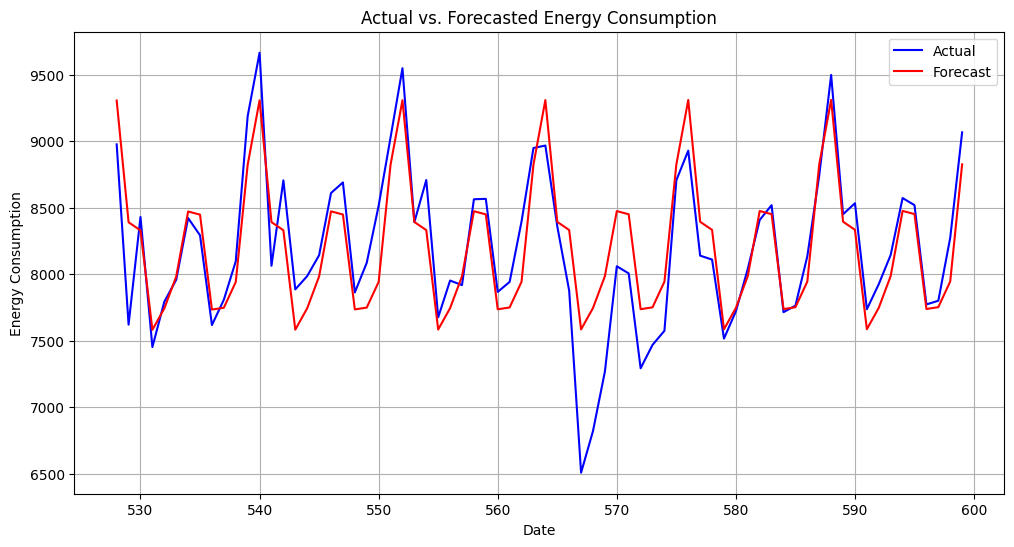

In [11]:
# Splitting the data into a training set (1973-2016) and a test set (2017-2022)
train_start_date = pd.to_datetime('1973-01-01')
train_end_date = pd.to_datetime('2016-12-31')
validation_start_date = pd.to_datetime('2017-01-01')
validation_end_date = pd.to_datetime('2022-12-31')

# Defining featues and target variable
features = ['TotalPrimaryEnergyProduction', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports', 't', 'PrimaryEnergyStockChange']
target = 'TotalPrimaryEnergyConsumption'

# Creating training and validation data subsets
train_data = data[(data['Date'] >= train_start_date) & (data['Date'] <= train_end_date)]
validation_data = data[(data['Date'] >= validation_start_date) & (data['Date'] <= validation_end_date)]

# Defining the best hyperparameters
best_hyperparameters = {
    'seasonal': 'add',
    'seasonal_periods': 12,
    'trend': 'add',
    'damped': True,
    'use_boxcox': True
}

# Winter's Exponential Smoothing model with the best hyperparameters
model = ExponentialSmoothing(train_data[target], seasonal=best_hyperparameters['seasonal'], 
                             seasonal_periods=best_hyperparameters['seasonal_periods'],
                             trend=best_hyperparameters['trend'], 
                             damped=best_hyperparameters['damped'],
                             use_boxcox=best_hyperparameters['use_boxcox'])
model_fit = model.fit()

# Forecasting on the validation data
forecast_validation = model_fit.forecast(steps=len(validation_data))

# Evaluation metrics for training
mae_train = mean_absolute_error(train_data[target], model_fit.fittedvalues)
mse_train = mean_squared_error(train_data[target], model_fit.fittedvalues)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((train_data[target] - model_fit.fittedvalues) / (train_data[target] + 1e-10))) * 100

# Evaluation metrics for validation
mae_validation = mean_absolute_error(validation_data[target], forecast_validation)
mse_validation = mean_squared_error(validation_data[target], forecast_validation)
rmse_validation = np.sqrt(mse_validation)
mape_validation = np.mean(np.abs((validation_data[target] - forecast_validation) / (validation_data[target] + 1e-10))) * 100

# Results
print("Training Set Metrics:")
print(f"MAE: {mae_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")

print("\nValidation Set Metrics:")
print(f"MAE: {mae_validation:.2f}")
print(f"RMSE: {rmse_validation:.2f}")
print(f"MAPE: {mape_validation:.2f}%")

# Plotting the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(validation_data.index, validation_data[target], label='Actual', color='blue')
plt.plot(validation_data.index, forecast_validation, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Actual vs. Forecasted Energy Consumption')
plt.legend()
plt.grid()
plt.show()


**Analysis**:

- Following hyperparameter tuning, a notable reduction in overfitting is observed, resulting in improved outcomes. This enhancement is visible in the Actual and Forecast plots for Consumption.

- In summary, for both Production and Consumption, the Winter's Exponential model initially demonstrated suboptimal performance. However, after hyperparameter tuning, significant improvements are evident in the results.
ed.
